# Chapter 20. Natural Language Processing

In [212]:
from __future__ import division
import math, random, re
from collections import defaultdict, Counter
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
from probability import normal_cdf, inverse_normal_cdf

[Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing) refers to computational techniques using language.  
It's a broad field, but we'll look at a few simple (and a few not-so-simple) techniques.

## Word Clouds

In Chapter 1, we computed word counts of users' interests.  
One approach to visualizing words and counts is with word clouds, which artistically plot the words with sizes proportional to their counts.  
When creating a word cloud, think about how you can make the axes convey some meaningful information.  
For example, let's look at a collection of data science-related buzzwords.  
Each buzzword has two numbers between 0 and 100 that represent:
1. how frequently it appears in job postings
2. how frequently it appears on resumes

In [213]:
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

When building the word cloud, let's scatter the buzzwords so that horizontal position indicates posting popularity and vertical position indicates resume popularity.  
This will result in a visualization that conveys a few basic insights:

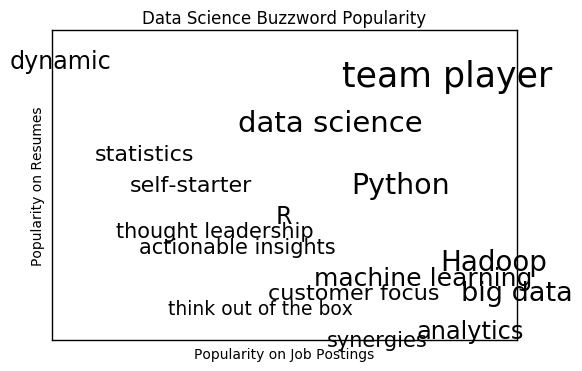

In [214]:
def text_size(total):
    """ equals 8 if the total is 0, 28 if the total is 200 """
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word, 
             ha='center', va='center',
             size=text_size(job_popularity + resume_popularity))
plt.title("Data Science Buzzword Popularity")
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

## n-gram Models

The DataSciencester VP of Search Engine Marketing wants to create thousands of web pages about data science so that your site will rank higher in search results for data-science-related terms.  
You try to explain to her that search engine algorithms are clever enough that this won't actually work, but she refuses to listen.  
Of course, she doesn't want to write thousands of web pages, nor does she want to pay a horde of "content strategists" to do so.  
Instead she asks you to programatically generate these web pages.  
To do this, we'll need some way of modeling language.  
One approach is to begin with a corpus of documents and learn a statistical model of language.  
For this example, we'll use Mike Loukides' essay titled ["What is Data Science?"](https://www.oreilly.com/ideas/what-is-data-science).  

Just like in Chapter 9, we'll use the `requests` library and `BeautifulSoup` to retrieve the data.  
There are a couple of issues that will need to be addressed.  
The first is that the apostrophes in the text are actually the [Unicode character](https://unicode-table.com/en/) `u"\u2019"`.  
We can deal with this by creating a helper function to replace them with normal apostrophes:

In [215]:
def fix_unicode(text):
    return text.replace(u"\u2019", "'")

The second issue is that once we get the text of a web page, we'll want to split it into a sequence of words and periods (so that we can tell where the sentences end).  
We can do this using `re.findall()`:

In [216]:
url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')
content = soup.find("div", "article-body")  # find article-body div
regex = r"[\w']+|[\.]"  # matches a word or a period
document = []
for paragraph in content("p"):
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)
    
print document[:20]  # print first 20 words for sanity check

[u"We've", u'all', u'heard', u'it', u'according', u'to', u'Hal', u'Varian', u'statistics', u'is', u'the', u'next', u'sexy', u'job', u'.', u'Five', u'years', u'ago', u'in', u'What']


We certainly could (and probably should) clean this data further.  
That being said, we'll work with the `document` as it is.

Now that we have the text as a sequence of words, we can model language in the following way:  
- Given some starting word ("book", for example) we look at all of the words that follow it in the source document(s) ("isn't", "a", "shows", "demonstrates", and "teaches").
- We randomly choose one of these to be the next word, and we repeat the process until we get to a period, which indicates the end of a sentence.  

We call this a [bigram model](https://en.wikipedia.org/wiki/Bigram), as it is determined completely by the frequency of the bigrams (word pairs) in the original data.  
What about a starting word?  
We can just randomly pick from words that follow a period.  
To start, lets precompute the possible word transitions.  
Recall that `zip` stops when any of its inputs is done, so that `zip(document, document[1:])` gives us precisely the pairs of consecutive elements of `document`:

In [217]:
bigrams = zip(document, document[1:])
transitions = defaultdict(list)
for prev, current in bigrams:
    transitions[prev].append(current)  

In [218]:
transitions["We've"]

[u'all', u'all', u'all']

Now we're ready to generate some sentences:

In [219]:
def generate_using_bigrams(transitions):
    current = "."  # this means that the next word will start a sentence.
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." then we're done

Running the next cell a few times will give you examples of the gibberish (albeit data-sciencey gibberish) sentences that are generated.

In [220]:
print generate_using_bigrams(transitions)
print generate_using_bigrams(transitions)
print generate_using_bigrams(transitions)

It's easer to hiking trails .
While rock solid consistency is try plotting and data problems ranging from it .
Point of my favorites is frequently missing do massive correlations across LinkedIn's membership .


We can make the sentences a bit more intelligible by looking at [trigrams](https://en.wikipedia.org/wiki/Trigram), which are triplets of consecutive words.  
More generally, you might look at [n-grams](https://en.wikipedia.org/wiki/N-gram) consisting of $n$ consecutive words, but three will be plenty for now.  
Now the transitions will depend on the previous *two* words:

In [221]:
trigrams = zip(document, document[1:], document[2:])
trigrams[:10]

[(u"We've", u'all', u'heard'),
 (u'all', u'heard', u'it'),
 (u'heard', u'it', u'according'),
 (u'it', u'according', u'to'),
 (u'according', u'to', u'Hal'),
 (u'to', u'Hal', u'Varian'),
 (u'Hal', u'Varian', u'statistics'),
 (u'Varian', u'statistics', u'is'),
 (u'statistics', u'is', u'the'),
 (u'is', u'the', u'next')]

In [222]:
trigram_transitions = defaultdict(list)
starts = []
for prev, current, next in trigrams:
    if prev == ".":              # if the previous "word" was a period
        starts.append(current)   # then this is a start word
    trigram_transitions[(prev, current)].append(next)

In [223]:
starts[:10]

[u'Five',
 u'0',
 u'But',
 u'The',
 u'Almost',
 u"There's",
 u'But',
 u'A',
 u"It's",
 u'Data']

In [224]:
trigram_transitions["We've", "all"]

[u'heard', u'heard', u'heard']

Notice that now we have to track the starting words separately.  
We can generate sentences in pretty much the same way:

In [225]:
def generate_using_trigrams(starts, trigram_transitions):
    current = random.choice(starts)  # choose a random starting word
    prev = "."                       # and precede it with a '.'
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next_word = random.choice(next_word_candidates)
        prev, current = current, next_word 
        result.append(current)
        if current == ".": return " ".join(result)

This approach produces better sentences such as:

In [226]:
print generate_using_trigrams(starts, trigram_transitions)
print generate_using_trigrams(starts, trigram_transitions)
print generate_using_trigrams(starts, trigram_transitions)

These are frequently called NoSQL databases or Non Relational databases though neither term is very effective R incorporates a fairly comprehensive graphics package Casey Reas' and Ben Fry's Processing is the state of the problem .
Data science enables the creation of data that bit .
ly are following their path .


The reason that the trigram sentences sound less gibberish-y than the bigram ones is because at each step the generation process has fewer choices, and at many steps only a single choice.  
As a result, you frequently generate phrases and even sentences that were seen verbatim in the original data.  
Having more data would improve the generated sentences, as would collecting $n$-grams from multiple essays about data science.

## Grammars

A different approach to modeling language is with [grammars](http://ccl.pku.edu.cn/doubtfire/NLP/Parsing/Introduction/Grammars%20and%20Parsing.htm), which are rules for generating sentences.  
In elementary school, you probably learned about the parts of speech and how to combine them.  
For example, if you had a really bad English teacher, you might say that a sentence necessarily consists of a noun followed by a verb.  
If you then have a list of nouns and verbs, you can generate sentences according to the rule.  
For this example we'll define a slightly more complicated grammar:

In [227]:
grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N", "_A _NP _P _A _N"],
    "_VP" : ["_V", "_V _VP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

The author made up the convention that names starting with underscores refer to [rules](https://en.wikipedia.org/wiki/Formal_grammar) that need further understanding, and that other names are [terminals](https://en.wikipedia.org/wiki/Terminal_and_nonterminal_symbols) that don't need further processing.  
For example, `"_S"` is the *sentence* rule, which produces a `"_NP"` (*noun phrase*) rule followed by a `"_VP"` (*verb phrase*) rule.  
The verb phrase rule can produce either the `"_V"` (*verb*) rule, or the verb rule followed by the noun phrase rule.  
Notice that the `"_NP"` rule contains itself in one of its productions.  
Grammars can be recursive, which allows even finite grammars like this to generate infinitely many different sentences.

How do we generate sentences from this grammar?  
We'll start with a list containing the sentence rule `["_S"]`.  
Then we'll repeatedly expand each rule by replacing it with a randomly chosen one of its productions.  
We stop when we have a list consisting solely of terminals.  
For example, one such progression might look like:

How do we implement this?  
To start, we'll create a simple helper function to identify terminals:

In [228]:
def is_terminal(token):
    return token[0] != "_"

Next we need to write a function that turns a list of tokens into a sentence.  
We'll look for the first nonterminal token.  
If we can't find one, that means that we have a completed sentence and we're done.  
If we *do* find a nonterminal, then we randomly choose one of its productions.  
If that production is a terminal (like a word), we simply replace the token with it.  
Otherwise it's a sequence of space-separated nonterminal tokens that we need to `split` and then splice into the current tokens.  
Either way, we repeat the process on a new set of tokens.  
Putting it all together we get:

In [229]:
def expand(grammar, tokens):
    for i, token in enumerate(tokens):
        # skip over terminals
        if is_terminal(token): continue
        # if we get here, we have found a non-terminal token and we need to choose a random replacement
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        # now call expand on the new list of tokens
        return expand(grammar, tokens)
    # if we get here we have all terminals and are done
    return tokens

Now we can start generating sentences:

In [230]:
def generate_sentence(grammar):
    return expand(grammar, ["_S"])

In [231]:
print generate_sentence(grammar)
print generate_sentence(grammar)
print generate_sentence(grammar)

['big', 'big', 'big', 'regression', 'near', 'linear', 'regression', 'about', 'linear', 'Python', 'near', 'linear', 'data science', 'is']
['linear', 'Python', 'near', 'linear', 'regression', 'trains', 'trains']
['data science', 'is']


Try changing the grammar by adding more words, more rules, your own parts of speech, and so on, until you're ready to generate as many web pages as your company needs.  
Grammars are actually more interesting when they're used in the other direction.  
Given a sentence, we can use a grammar to [parse](http://language.worldofcomputing.net/parsing/what-is-parsing.html) the sentence.  
This then allows us to identify subjects and verbs and helps us make sense of the sentence.  
Using data science to generate text is a neat trick; using it to *understand* text is more magical.  
See the "For Further Investigation" section at the end of this chapter for libraries that you could use for this.

## An Aside: Gibbs Sampling

Generating samples from some distributions is easy.  
We can get uniform random variables with:

In [232]:
random.random()

0.5368942039389607

and normal random variables with:

In [233]:
inverse_normal_cdf(random.random())

1.127462387084961

Some distributions, however, are harder to sample from.  
[Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) is a technique for generating samples from [multidimensional distributions](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) when we only know some of the [conditional distributions](http://www.statisticshowto.com/conditional-distribution/).  .  
For example, imagine rolling two dice.  
Let $x$ be the value of the first die and $y$ be the sum of the dice, and imagine that you wanted to generate many (x, y) pairs.  
In this case it's easy to generate the samples directly:

In [234]:
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

In [235]:
direct_sample()

(6, 10)

Now imagine that you only knew the conditional distributions.
The distribution of $y$ conditional on $x$ is easy -- if you know the value of $x$, $y$ is equally likely to be $x$+1, $x$+2, $x$+3, $x$+4, $x$+5, or $x$+6:

In [236]:
def random_y_given_x(x):
    """ equally likely to be x+1, x+2, ..., x+6 """
    return x + roll_a_die()

The other direction is more complicated.  
For example, if you know that $y$ is 2, then necessarily $x$ is 1 (since the only way two dice can sum to to 2 is if both of them are 1).  
If you know that $y$ is 3, then $x$ is equally likely to be 1 or 2.  
Similarly, if $y$ is 11, then $x$ has to be either 5 or 6:

In [237]:
def random_x_given_y(y):
    if y <= 7:
        # if the total is 7 or less, then the first die is equally likely to be 1, 2, ..., (total-1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, then the first die is equally likely to be (total-6), (total-5), ..., 6
        return random.randrange(y - 6, 7)

The way Gibbs sampling works is that we start with any (valid) value for $x$ and $y$ and then repeatedly alternate with replacing $x$ with a random value picked conditional on $y$ and replacing $y$ with a random value picked conditional on x.  
After a number of iterations, the resulting values of $x$ and $y$ will represent a sample from the unconditional joint distribution:

In [238]:
def gibbs_sample(num_iters=100):
    x, y = 1, 2  # doesn't really matter, as long as they are valid
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

In [239]:
print gibbs_sample(num_iters=100)
print gibbs_sample(num_iters=100)
print gibbs_sample(num_iters=100)

(6, 8)
(4, 9)
(2, 8)


You can check that the Gibbs sample gives similar results to the direct sample:

In [240]:
def compare_distributions(num_samples=1000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [241]:
compare_distributions(num_samples=1000)

defaultdict(<function __main__.<lambda>>,
            {(1, 2): [32, 29],
             (1, 3): [26, 28],
             (1, 4): [38, 29],
             (1, 5): [33, 20],
             (1, 6): [19, 29],
             (1, 7): [25, 40],
             (2, 3): [18, 18],
             (2, 4): [32, 32],
             (2, 5): [18, 36],
             (2, 6): [28, 25],
             (2, 7): [22, 33],
             (2, 8): [29, 28],
             (3, 4): [19, 34],
             (3, 5): [25, 26],
             (3, 6): [29, 25],
             (3, 7): [25, 19],
             (3, 8): [38, 21],
             (3, 9): [32, 30],
             (4, 5): [16, 32],
             (4, 6): [32, 26],
             (4, 7): [28, 25],
             (4, 8): [27, 30],
             (4, 9): [24, 28],
             (4, 10): [35, 18],
             (5, 6): [35, 29],
             (5, 7): [32, 26],
             (5, 8): [25, 26],
             (5, 9): [35, 32],
             (5, 10): [23, 24],
             (5, 11): [32, 34],
             (6, 7): [30,

We'll use this technique in the next section.

## Topic Modeling